In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.sparse as sps
import scipy.optimize as optimization
import seaborn as sns

from numba import njit

#%matplotlib inline
#%matplotlib widget

In [372]:
@njit()
def diagonalization(Hmat):
  val, vec = np.linalg.eigh(Hmat)
  return val, vec

In [380]:
class Hamiltonian():
  """ In short words, this class is an object that each method will be a characteristic of the Hamiltonian."""
  def __init__(self, h0, length, Jcom, kappa, PBC, Jres = 1.):
    """
    This will set all the parameters, is also possible to define a not constant J. 
    If the length of Js is not as large as the system size will fill the other values of J with the Jres value (default is 1.)
    """
    self.h = h0
    self.L = length
    self.PBC = PBC
    self.k = kappa
    if type(Jcom) == float or type(Jcom) == int :
      self.J = np.ones(self.L)*Jcom
    else:
      self.J = np.concatenate((Jcom,np.ones(self.L-Jcom.shape[0])*Jres))

  def __zero_subspace(self,eigsystem, eps=10**(-4)):
    size = eigsystem[0].shape[0] #this returns number of eigenvalues
    zeros= eigsystem[0][np.abs(eigsystem[0]) <=eps]
    if len(zeros)<1:
        return eigsystem[1].T
    
    zeroindex = [int(size/2)-1,int(size/2)]
    vectors = eigsystem[1].T
    zeroeigenv=[vectors[i] for i in zeroindex]

    if(len(zeroeigenv))!=2:
        print("Alert!, there is no double degeneracy:"+str(len(zeroeigenv)))
        return
    a,b = np.zeros(size), np.zeros(size)

    for i in range(2):
        a += zeroeigenv[i] + np.concatenate((zeroeigenv[i][int(size/2):],zeroeigenv[i][:int(size/2)]))
        b += (-1)**(i)*np.concatenate((zeroeigenv[i][int(size/2):],zeroeigenv[i][:int(size/2)])) + (-1)**(i+1)*zeroeigenv[i]

    a = a/np.linalg.norm(a)
    b = b/np.linalg.norm(b)
    #print("Zero indexes",zeroindex,"a,b",a,b)

    vectors[zeroindex[0]] = (a+b)/np.sqrt(2)
    vectors[zeroindex[1]] = (a-b)/np.sqrt(2)
    return vectors
 
  def matrix(self):
    """One has to be careful in this part because if PBC is true then this returns a lambda function object. matrix()(p) where
    for each p one obtains the parity, but in PBC False this return only one matrix"""
    TL = sps.csr_matrix(np.array([[1,0],[0,0]]))
    TR = sps.csr_matrix(np.array([[0,1],[0,0]]))
    BL = sps.csr_matrix(np.array([[0,0],[1,0]]))
    BR = sps.csr_matrix(np.array([[0,0],[0,1]]))

    A = sps.dok_matrix((self.L,self.L),dtype=np.float32)
    A.setdiag(self.h)
    A.setdiag(-self.J/2, k = 1)
    A.setdiag(-self.J/2, k = -1)

    B = sps.dok_matrix((self.L,self.L),dtype=np.float32)
    B.setdiag(-self.k*self.J/2, k = 1)
    B.setdiag(self.k*self.J/2, k = -1)

    if self.PBC:
      H = np.zeros((2, 2*self.L, 2*self.L))
      for p in range(2):
          A.setdiag(((-1)**p)*self.J/2, k=self.L-1)
          A.setdiag(((-1)**p)*self.J/2, k=1-self.L)
          B.setdiag(-((-1)**p)*self.k*self.J/2, k=self.L-1)
          B.setdiag(((-1)**p)*self.k*self.J/2, k=1-self.L)
          H[p] = (sps.kron(TL, A) + sps.kron(TR, B) + sps.kron(BL, -B) + sps.kron(BR, -A)).toarray()
      Hmat = lambda x: H[x]
    else:
      Hmat = sps.kron(TL, A) + sps.kron(TR, B) + sps.kron(BL, -B) + sps.kron(BR, -A)
      Hmat = Hmat.toarray()
    return Hmat
  
  def eigensystem(self):
    """
    Generates the eigensytem for the parameters defined. 
    It returns a tuple where first element are the eigenvalues and second element are the eigenvectors, 
    if PBC flag is true then returns 4*L eigenvalues and eigenvectors, if not only returns 2*L eigenvalues and eigenvectors.
    """
    H = self.matrix()
    if not self.PBC:
      eigsystem = diagonalization(H)
      vectors = self.__zero_subspace(eigsystem)
      return eigsystem[0], vectors
    else:
      eigsystem_0 = diagonalization(H(0))
      eigsystem_1 = diagonalization(H(1))
      values = np.concatenate((eigsystem_0[0], eigsystem_1[0]))
      vectors = np.concatenate((eigsystem_0[1].T, eigsystem_1[1].T))
      #print(vectors.shape)
      return values, vectors
    
  def U_matrix(self, vectors=None):
    """if PBC is true then this return a lambda function object.matrix()(p) where
    for each p one obtains the parity, but in PBC False this return only one matrix"""
    
    TL = np.array([[1,0],[0,0]])
    TR = np.array([[0,1],[0,0]])
    BL = np.array([[0,0],[1,0]])
    BR = np.array([[0,0],[0,1]])
    L=self.L
    
    if vectors == None:
      vectors = self.eigensystem()[1]
    
    u=lambda x: vectors[(2*x+1)*L:(2*x+2)*L,:L].T
    v=lambda x: vectors[(2*x+1)*L:(2*x+2)*L,L:].T
      
    if self.PBC==False:  
      U=np.kron(TL,u(0))+np.kron(BR,u(0).conj())+np.kron(TR,v(0).conj())+np.kron(BL,v(0))
    else:  
      U=lambda x: np.kron(TL,u(x))+np.kron(BR,u(x).conj())+np.kron(TR,v(x).conj())+np.kron(BL,v(x))
    return U
    
  def greenFunc(self, vectors=None):
    """if PBC is true then this returns a lambda function object.matrix()(p) where
    for each p one obtains the parity, but in PBC False this return only one matrix"""
    
    TL = np.array([[1,0],[0,0]])
    TR = np.array([[0,1],[0,0]])
    BL = np.array([[0,0],[1,0]])
    BR = np.array([[0,0],[0,1]])
    L=self.L
      
    if vectors == None:
      vectors = self.eigensystem()[1]
        
    u=lambda x: vectors[(2*x+1)*L:(2*x+2)*L,:L].T
    v=lambda x: vectors[(2*x+1)*L:(2*x+2)*L,L:].T
    
    if self.PBC==False:
      G = u(0)@u(0).conj().T
      F = u(0)@v(0).conj().T
    else:
      G = lambda x: u(x)@u(x).conj().T
      F = lambda x: u(x)@v(x).conj().T
    return G,F
  
  def M(self,vectors=None):
    """if PBC is true then this returns a lambda function object.matrix()(p) where
    for each p one obtains the parity, but in PBC False this returns only one matrix"""
    L=self.L      
    Id=np.eye(L)
    if vectors == None:
        GF=self.greenFunc()
    else:
        GF=self.greenFunc(vectors)
    if self.PBC:
        return lambda x: Id-2*(GF[0](x)+GF[1](x))
        
    return Id-2*(GF[0]+GF[1])
      
  def spincorr(self,i,j,M=None):
    """if PBC is true then this returns a lambda function object.matrix()(p) where
    for each p one obtains the parity, but in PBC False this returns only one matrix"""
    
    if M == None:
        M=self.M()
    
    if self.PBC:
        return lambda x: np.linalg.det(M(x)[i:j,i+1:j+1])
        
    return np.linalg.det(M[i:j,i+1:j+1])
  def entropy_ent(self,l,GF=None):
    """if PBC is true then this returns a lambda function object.matrix()(p) where
    for each p one obtains the parity, but in PBC False this returns only one matrix"""
    
    SY = np.array([[0.0,-1.0],[1.0,0.0]])
    SX = np.array([[0.0,1.0],[1.0,0.0]])
    L=self.L      
    Id=np.eye(L)
      
    ones = lambda x: np.abs(x-1.)>10**(-4)
      
    if GF == None:
        G,F=self.greenFunc()
    if self.PBC:
        A= lambda x: diagonalization(1j*(np.kron(SY,Id[:l,:l]-2*G(x)[:l,:l])+np.kron(SX,-2*F(x)[:l,:l])))[0][l:]
        S= lambda x: (-1)*sum([(jj+1)/2.0*np.log((jj+1)/2.0)+(1-jj)/2.0*np.log((1-jj)/2.0) for jj in A(x) if ones(jj)])
        return S
    A=diagonalization(1j*(np.kron(SY,Id[:l,:l]-2*G[:l,:l])+np.kron(SX,-2*F[:l,:l])))[0][l:]
    S=(-1)*sum([(jj+1)/2.0*np.log((jj+1)/2.0)+(1-jj)/2.0*np.log((1-jj)/2.0) for jj in A if ones(jj)])
    return S

Text(0, 0.5, '$E$')

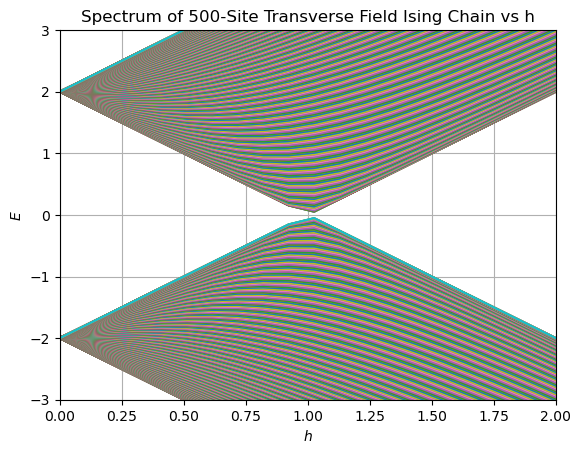

In [171]:
L=500
J=1.
kappa=1.
Hs = np.r_[0:4:40j]
ens = []
eigv = np.zeros((len(Hs), 2*L , 1), dtype=float)


for (i,h) in enumerate(Hs):
  H = Hamiltonian(h, L, J, kappa, PBC=True)
  val = H.eigensystem()
  ens.append(val[0]*2)

  
  
# We plot the spectrum.
# Zoom as you wish, if your %matplotlib notebook magic is properly working (not in Colab, apparently)
plt.figure()
plt.plot(Hs, ens, '-')
plt.title(r'Spectrum of '+str(L)+r'-Site Transverse Field Ising Chain vs h')
plt.grid()
plt.xlim((0,2))
plt.ylim((-3,3))
plt.xlabel(r'$h$')
plt.ylabel(r'$E$')


[[ 0.25 -0.5  -0.5   0.   -0.5   0.5 ]
 [-0.5   0.25 -0.5   0.5   0.   -0.5 ]
 [-0.5  -0.5   0.25 -0.5   0.5   0.  ]
 [ 0.    0.5  -0.5  -0.25  0.5   0.5 ]
 [-0.5   0.    0.5   0.5  -0.25  0.5 ]
 [ 0.5  -0.5   0.    0.5   0.5  -0.25]]


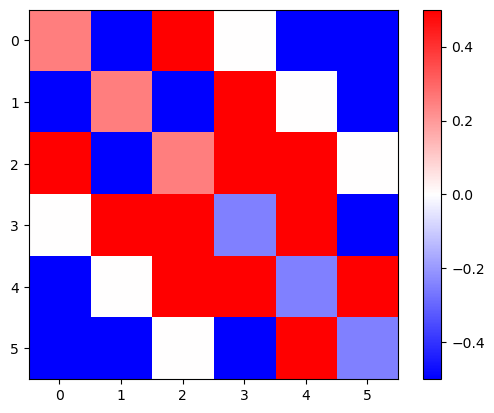

In [282]:
#Sanity Check

H = Hamiltonian(0.25, 3, 1., 1., PBC=True)
print(H.matrix()(1))
plt.figure()
plt.imshow(H.matrix()(0),interpolation='none',cmap='bwr')
plt.colorbar()
plt.show()

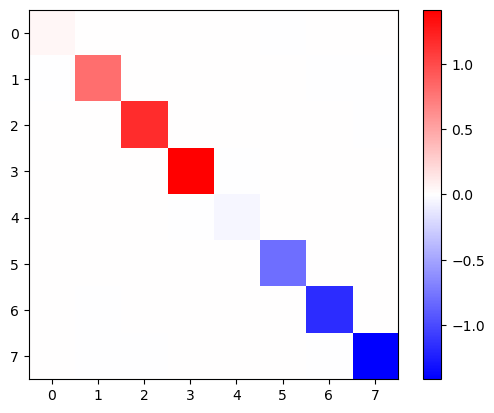

[-1.4134192  -1.16612325 -0.80009785 -0.04739379  0.04739379  0.80009785
  1.16612325  1.4134192 ]
[ 0.39537369  0.11310909 -0.11310909 -0.39537369  0.47817528  0.31974111
  0.31974111  0.47817528] [ 0.47817528  0.31974111  0.31974111  0.47817528  0.39537369  0.11310909
 -0.11310909 -0.39537369]


In [302]:
## Sanity Check
L=4
H = Hamiltonian(0.5,L,1,1,PBC=False)
E,V=H.eigensystem()
U=H.U_matrix()
Udagger=U.T
Hd=Udagger@H.matrix()@U
plt.figure()
plt.imshow(Hd,interpolation='none',cmap='bwr')
plt.colorbar()
plt.show()
print(E)
print(V[3],V[4])



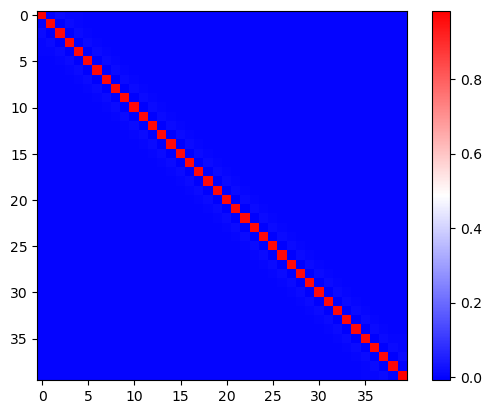

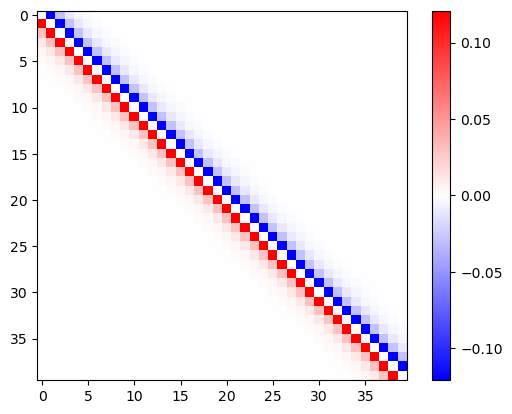

In [328]:
#Sanity Check
U = H.U_matrix()
G,F=H.greenFunc()

plt.figure()
plt.imshow(G,interpolation='none',cmap='bwr')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(F,interpolation='none',cmap='bwr')
plt.colorbar()
plt.show()


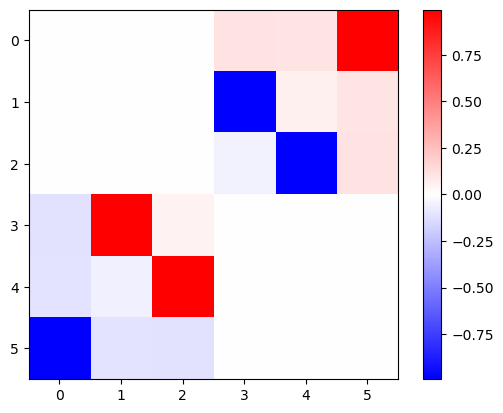

[1. 1. 1.]
0


In [377]:
#Sanity Check
L=3
h0=0.1
J=1.0
H = Hamiltonian(h0,L,J,1,PBC=False)
SY = np.array([[0,-1.0],[1.0,0]])
SX = np.array([[0,1.0],[1.0,0]])
Id=np.eye(L)
G,F=H.greenFunc()
SS=(np.kron(SY,Id-2*G)+np.kron(SX,-2*F))
plt.figure()
plt.imshow(SS,interpolation='none',cmap='bwr')
plt.colorbar()
plt.show()
B=diagonalization(1j*SS)

A=B[0][L:]
ones = lambda x: np.abs(x-1.)>10**(-4)
S=(-1)*sum([(jj+1)/2.0*np.log((jj+1)/2.0)+(1-jj)/2.0*np.log((1-jj)/2.0) for jj in A if ones(jj)])

print(A)
print(S)

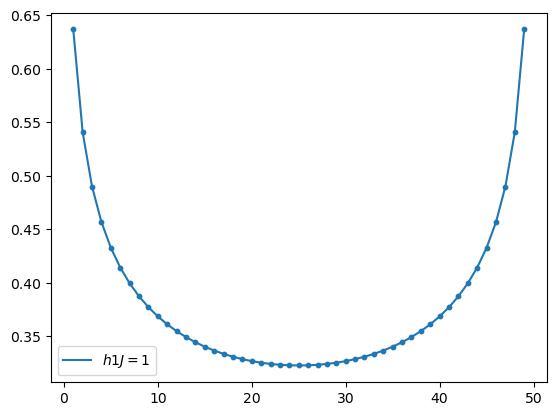

In [287]:
## Correlations:

L=50
h=1
J=1
plt.figure()
corr=[0 for i in range(L)]
H = Hamiltonian(h,L,J,1,PBC=True)
for l in range(L):
    corr[l]=H.spincorr(0,l)(0)
    
plt.scatter(range(1,L),corr[1:],s=10)
plt.plot(range(1,L),corr[1:],label=r"$h$"+str(h)+"$J=$"+str(J))
plt.legend()

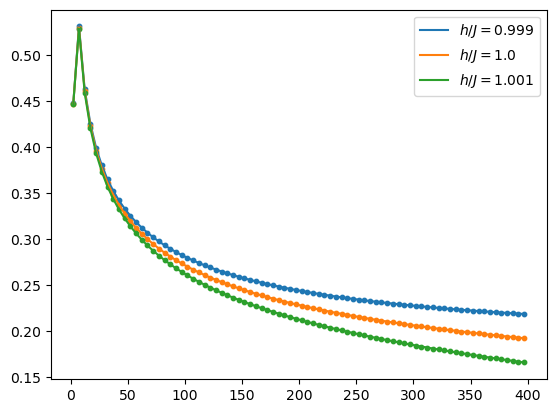

In [288]:
## Correlations:
L=[i for i in range(2,400,5)]
jh=[0.999, 1.0,1.001]

plt.figure()
for h in jh:
    corr=[0 for i in range(len(L))]
    for l in range(len(L)):
        H = Hamiltonian(h,L[l],1,1,PBC=True)
        corr[l]=H.spincorr(0,int(L[l]/2))(0)
    plt.scatter(L,corr,s=10)
    plt.plot(L,corr,label=r"$h/J=$"+str(h))
plt.legend()


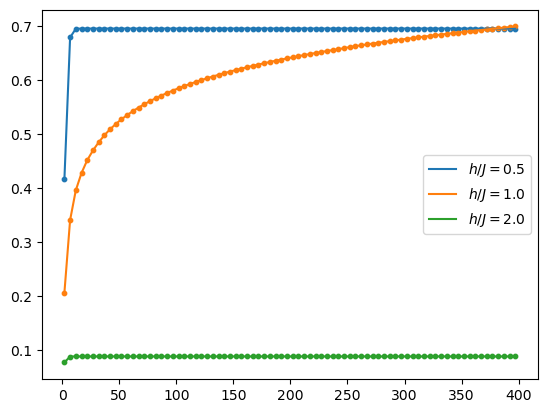

In [383]:
# Entropy
L=[i for i in range(2,400,5)]
jh=[0.5, 1.0,2.0]

plt.figure()
for h in jh:
    corr=[0 for i in range(len(L))]
    for l in range(len(L)):
        H = Hamiltonian(h,L[l],1,1,PBC=False)
        corr[l]=H.entropy_ent(int(L[l]/2.0))
    plt.scatter(L,corr,s=10)
    plt.plot(L,corr,label=r"$h/J=$"+str(h))
plt.legend()
